# Spanish Translation A/B Test

**Goal:**
1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
1. Explain why that might be happening. Are the localized translations really worse?
1. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")

**Statistical functions ( scipy. stats )** This module contains a large number of probability distributions as well as a growing library of statistical functions. Each univariate distribution is an instance of a subclass of rv_continuous ( rv_discrete for discrete distributions)

In [2]:
import os
os.getcwd()
from scipy.stats import ttest_ind

## Load datasets

In [3]:
df_test = pd.read_csv('datasets/02-SpanishTranslationABTest/test_table.csv')
df_user = pd.read_csv('datasets/02-SpanishTranslationABTest/user_table.csv')

## EDA

In [4]:
df_test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [6]:
print('Variable', '   ', 'Count of unique value','  ', 'content')
for column in df_test.columns:
    uniques = df_test[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:10])

Variable     Count of unique value    content
user_id              453321	 [315281 497851 848402 290051 548435 540675 863394 527287 261625  10427]
date                    5	 ['2015-12-03' '2015-12-04' '2015-11-30' '2015-12-01' '2015-12-02']
source                  3	 ['Direct' 'Ads' 'SEO']
device                  2	 ['Web' 'Mobile']
browser_language        3	 ['ES' 'Other' 'EN']
ads_channel             6	 [nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other']
browser                 7	 ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera']
conversion              2	 [1 0]
test                    2	 [0 1]


In [7]:
df_user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [8]:
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in df_user.columns:
    uniques = df_user[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:7])

Variable     count of unique value    content
user_id              452867	 [765821 343561 118744 987753 554597  62371 987967]
sex                     2	 ['M' 'F']
age                    52	 [20 27 23 29 31 21 49]
country                17	 ['Mexico' 'Nicaragua' 'Colombia' 'Venezuela' 'Spain' 'Ecuador' 'Paraguay']


In [9]:
# Check uniqueness
#print('Test ID:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique()) == len(test))
print('Test table Unique User Ids:\t', len(df_test['user_id'].unique()),'\t',
      len(df_test['user_id'].unique())==len(df_test['user_id']) )
print('User table Unique User Ids:\t', len(df_user['user_id'].unique()),'\t',
      len(df_user['user_id'].unique())==len(df_user['user_id']) )

Test table Unique User Ids:	 453321 	 True
User table Unique User Ids:	 452867 	 True


Conclusion:
It is clear that two tables do not have repeated users and for some users in the test set, we miss their information about sex, age and country. Thus, when joining, we have to guarantee the compeleteness of user ids in the test table. I am planning to let user table to left join test table.

## Q1: Confirm that the test is negative

In [10]:
# Merge two datasets: left joining by user_id
data = pd.merge(df_test,df_user,how='left',on='user_id')

Before we confrim that the old version of the site with just one translation across Spain and LatAm performs better, we should check that if it is true that conversion is high in Spain.

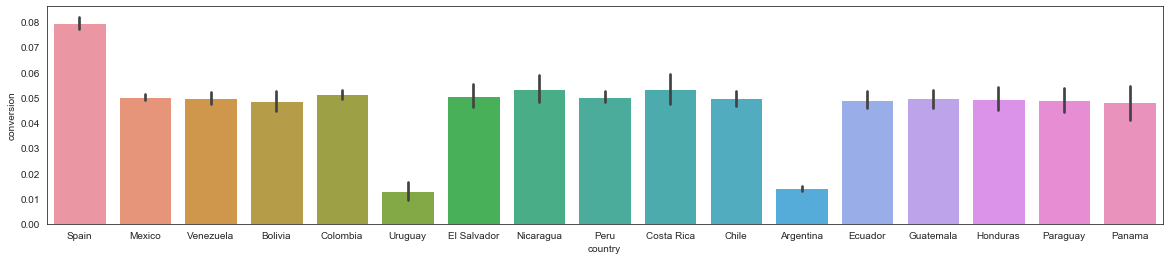

In [11]:
fig, ax=plt.subplots(1,1,figsize=(20,4))
sns.barplot(x=data['country'],y=data['conversion'])

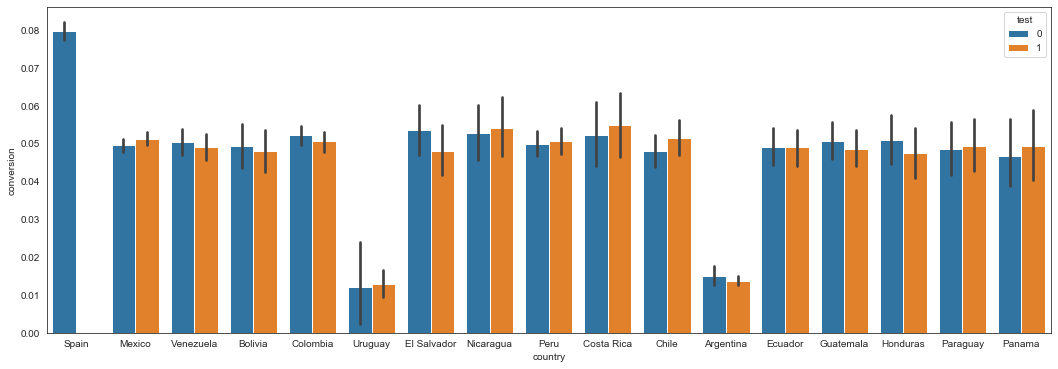

In [12]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax)
plt.show()

Obviously, Spain does have the highest mean conversion rate among all countries. Now I am trying to confirm that the test is negative by using t test.

### T test

**data_goal['test']==0** means: he was in control. That is, he saw the old translation written by a Spaniard

In [13]:
# A/B test
test_data = data[data['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion'].values
cont_val = test_data[test_data['test'] == 0]['conversion'].values

print(test_val.mean(), '\t', cont_val.mean())

0.043424713982118966 	 0.04833042316066309


In [14]:
print(ttest_ind(test_val, cont_val, equal_var=False))

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


We can see that control group without changing translation has a converting at 4.8%, however, users in test group with **localized translation** just convert at 4.3%. It does have a negative effect for changing translation.

## Q2. Explain why that might be happening. Are the localized translations really worse?

In order to answer this question, I will first visualize multiple variables by breaking data into control and test group to give me some insights.

In [15]:
test_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


In [16]:
# In order to use plot template
data_all = data
data = test_data

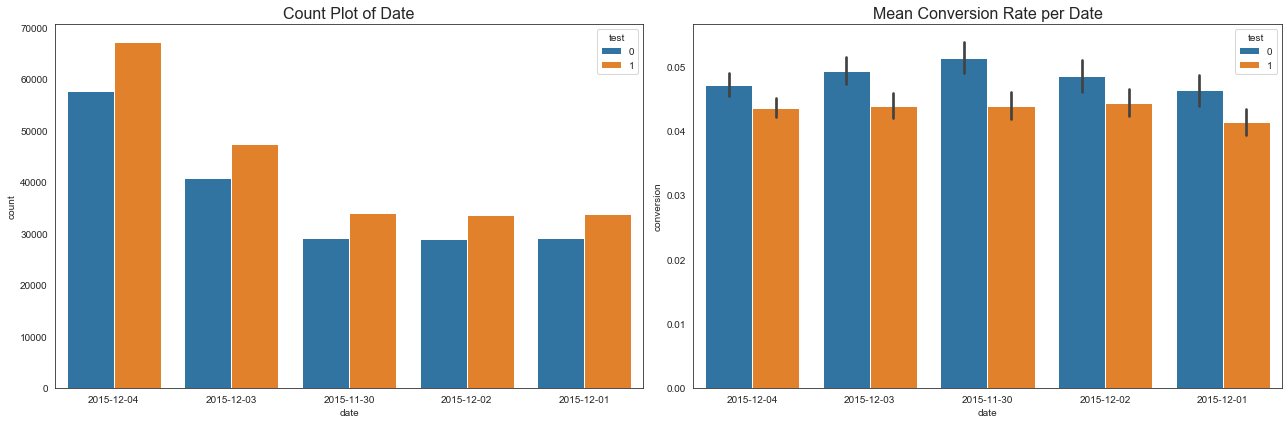

In [17]:
# Visualization of different dates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='date', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Date', fontsize=16)

sns.barplot(x='date', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)
plt.tight_layout()
plt.show()

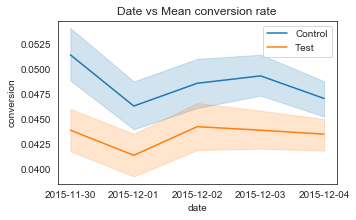

In [25]:
# Date variable visualization
plt.subplots(1,1,figsize=(5,3))
plt.title('Date vs Mean conversion rate')
sns.lineplot(x='date',y='conversion',data=data[data['test']==0],err_style='band',label='Control')
sns.lineplot(x='date',y='conversion',data=data[data['test']==1],err_style='band',label='Test');

plt.legend();

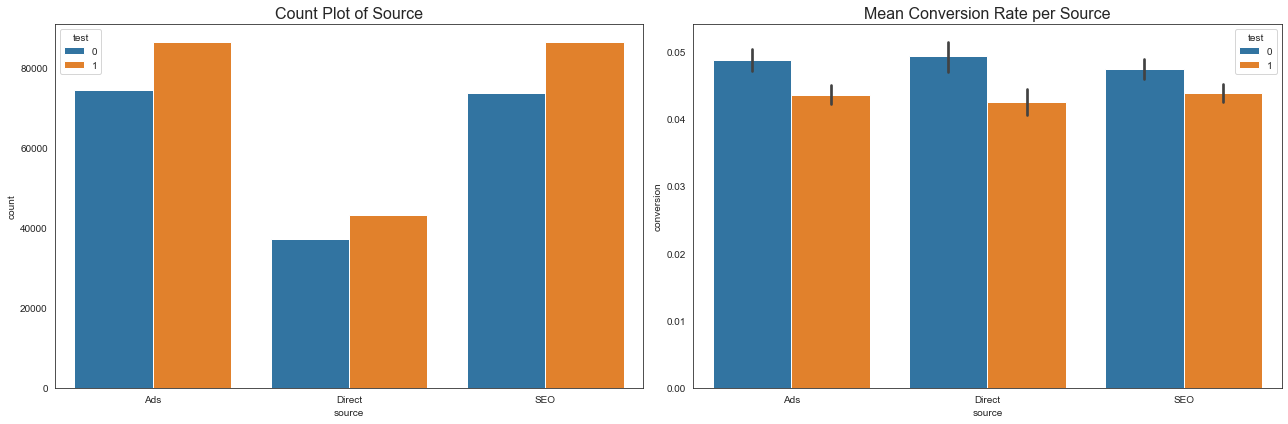

In [26]:
# Visualization of different source
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)

sns.barplot(x='source', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

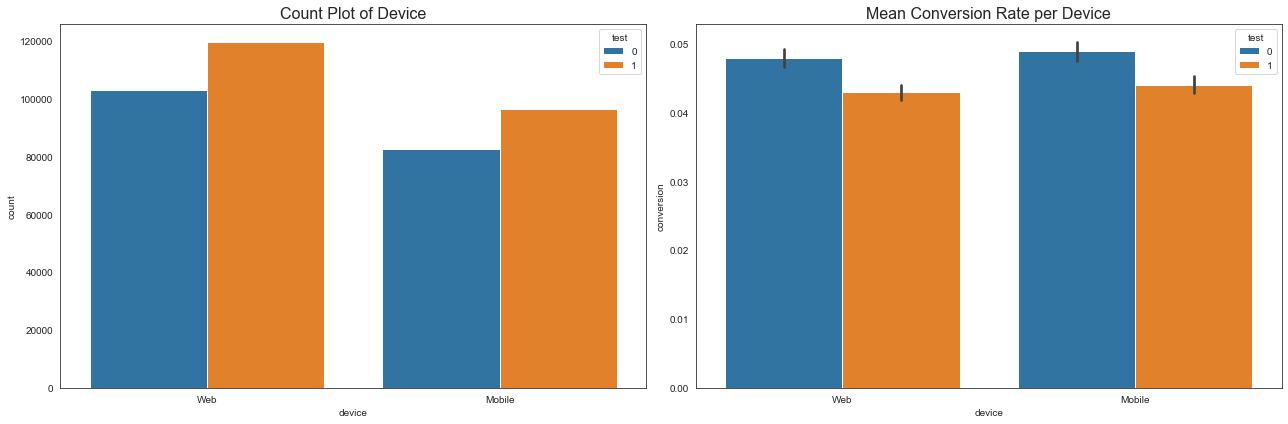

In [27]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='device', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Device', fontsize=16)

sns.barplot(x='device', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Device', fontsize=16)
plt.tight_layout()
plt.show()

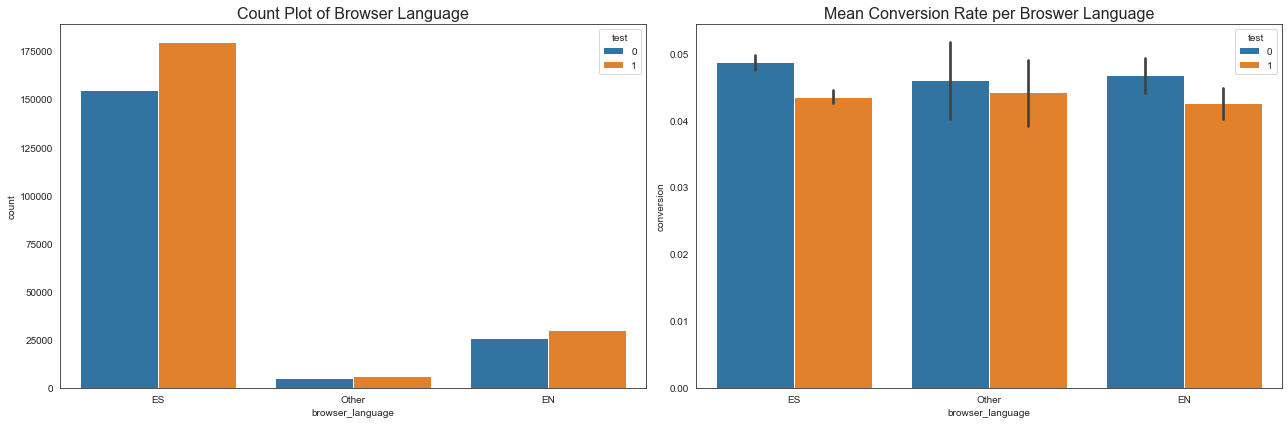

In [28]:
# Visualization of different browser_language
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser_language', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser Language', fontsize=16)

sns.barplot(x='browser_language', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Broswer Language', fontsize=16)
plt.tight_layout()
plt.show()

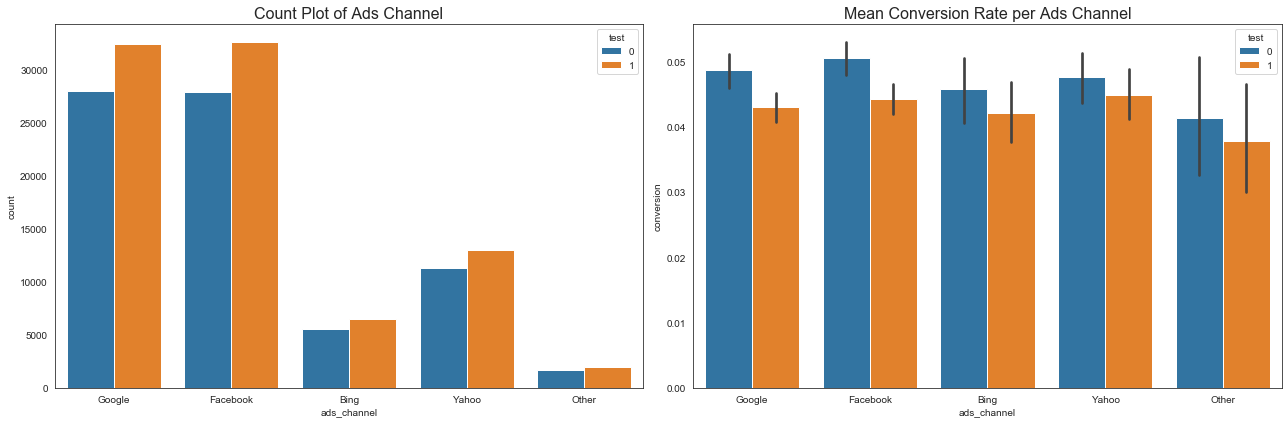

In [29]:
# Visualization of different ads_channel
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ads_channel', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Ads Channel', fontsize=16)

sns.barplot(x='ads_channel', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Ads Channel', fontsize=16)
plt.tight_layout()
plt.show()

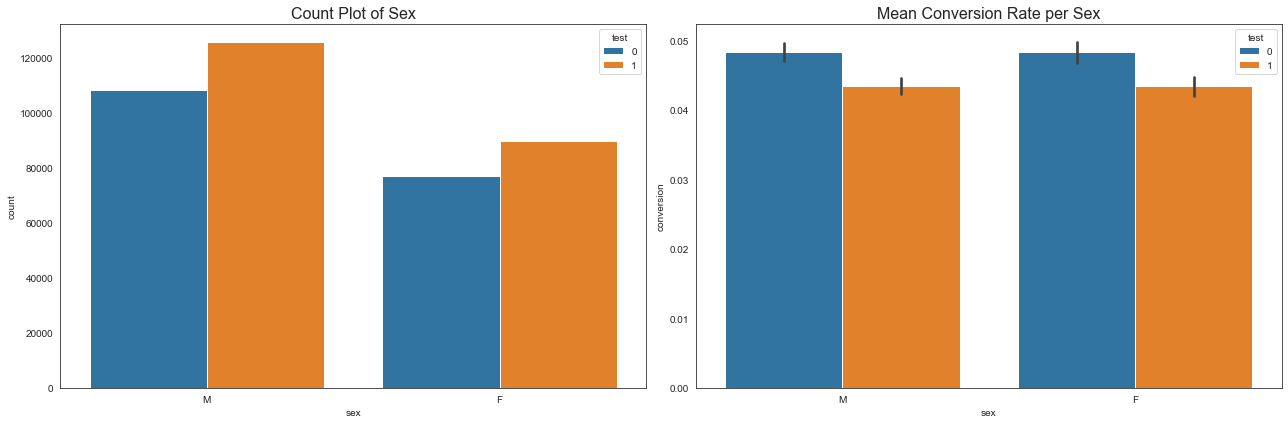

In [30]:
# Visualization of different Sex
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)

sns.barplot(x='sex', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Sex', fontsize=16)
plt.tight_layout()
plt.show()

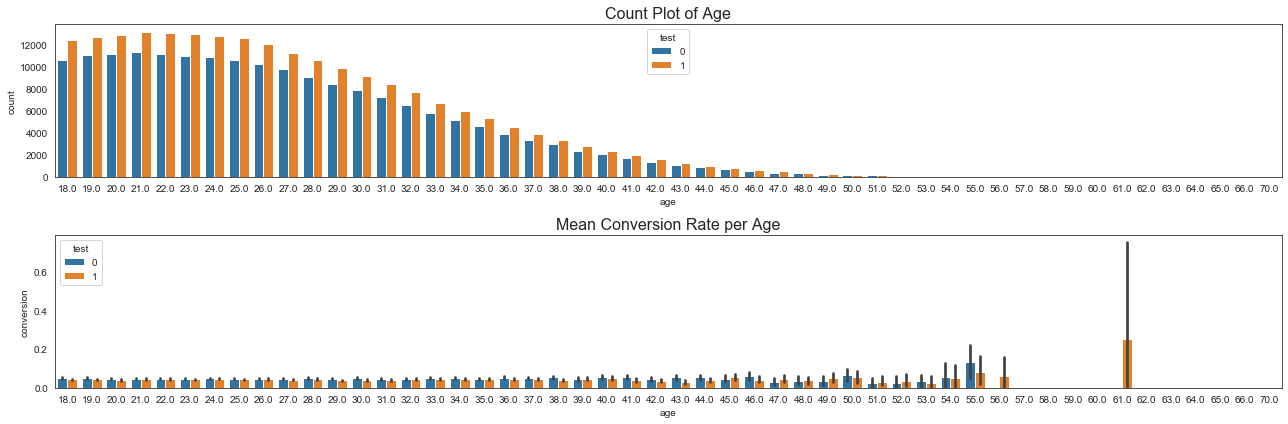

In [31]:
# Visualization of different ages
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 6))
sns.countplot(x='age', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Age', fontsize=16)

sns.barplot(x='age', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Age', fontsize=16)
plt.tight_layout()
plt.show()

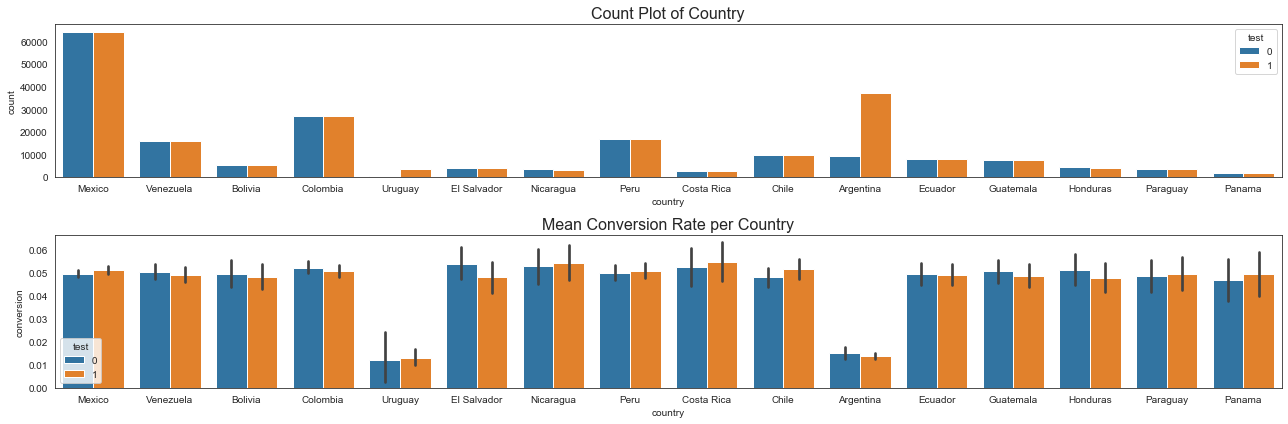

In [32]:
# Visualization of different countries
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 6))
sns.countplot(x='country', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)

sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

From coutry variable plots, it is clear that there are two contries, Uruguay and Argentina, that **their control and test group have different number of users**, which is **not acceptable** due to other countries all keep the 50/50 pattern. I think what fraction of visitors you want to be in control or test group should keep consistent on each level. Further, although the overall conversion rate of control is over that of test, we find that it is not right for each Spanish speaking country, which indicates changing to localized translation might be essentially not bad. Thus, it is worth doing a t test here.

Now, let check for each country

In [33]:
countries = [name for name in data['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = data[(data['country'] == country) & (data['test'] == 1)]['conversion'].values
    cont_val = data[(data['country'] == country) & (data['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  

After we control for country, the test clearly appears non significant. Now we know that a localized translation does not result in conversion rate drop.

## Q3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

The process we try to identify what was wrong tells us the main problem is about **country variable**. Our design for users in control or test group are not even on some countries, which might lead to noise for our experiment. Further, when calibrating the model on each country level, the result is not significant anymore. Thus, I tend to design an algorithm to **sanity check** problem about country, like if users are evenly divided into control and test groups, or if the result is significant on each country.

In [34]:
def sanitycheck(data,error):
    # no need to include users in Spain
    data = data[data['country']!='Spain']
    country_name = data['country'].dropna().unique()
    sig_country=[]
    print('{0:15s} {1:>15s} {2:>17s} {3:>12s} {4:>23s}'.
          format('Country', 'Mean of Control','Mean of Test', 'P-Value', 'No.Control/No.Test'))
    print('-' * 85)
    # check each country
    for country in country_name:
        data_country = data[data['country']==country]
        # split into control and test group
        cont_country = data_country[data_country['test']==0].conversion.values
        test_country = data_country[data_country['test']==1].conversion.values
        p_value=ttest_ind(cont_country, test_country, equal_var=False).pvalue
        if p_value < error:
            sig_country.append(country)
        ratio = len(cont_country)/len(test_country)
        print('{0:15s} {1:10.5f} {2:20.5f} {3:15f} {4:15.2f}'.
              format(country,cont_country.mean(),test_country.mean(),p_value,ratio))
    if len(sig_country)==len(country_name):
        print('Everything is good and the result can be trusted!')
        return('TRUE')
    else:
        print('There is at least something wrong among one of countries, its result is not significant. Please check.' )
        return('FALSE')

Significant level: 0.05

In [35]:
sanitycheck(data,0.05)

Country         Mean of Control      Mean of Test      P-Value      No.Control/No.Test
-------------------------------------------------------------------------------------
Mexico             0.04949              0.05119        0.165544            1.00
Venezuela          0.05034              0.04898        0.573702            1.02
Bolivia            0.04937              0.04790        0.718885            1.00
Colombia           0.05209              0.05057        0.423719            1.00
Uruguay            0.01205              0.01291        0.879764            0.11
El Salvador        0.05355              0.04795        0.248127            1.01
Nicaragua          0.05265              0.05418        0.780400            1.03
Peru               0.04991              0.05060        0.771953            1.00
Costa Rica         0.05226              0.05474        0.687876            1.00
Chile              0.04811              0.05130        0.302848            1.00
Argentina          0.01507 

'FALSE'